# Lab 1

## Part 2: Neural Machine Translation in the wild
In the second part of the homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.
* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* or just fine-tunning BERT)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__
Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext
! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2020-04-06 18:46:01--  https://raw.githubusercontent.com/ml-mipt/ml-mipt/advanced/homeworks/Lab1_NLP/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  27.7MB/s    in 0.4s    

2020-04-06 18:46:02 (27.7 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [ ]:
!pip install youtokentome

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


In [ ]:
from my_network import *
from utils import *

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
import youtokentome as yttm

with open('src.txt', "w") as from_out, open("trg.txt", "w") as to_out, open("data.txt") as data:
    for line in data.readlines():
        to, fr = line.strip().split('\t')[:2]
        print("<sos> " + ' '.join(tokenize(fr)) + " <eos>", file=from_out)
        print("<sos> " + ' '.join(tokenize(to)) + " <eos>", file=to_out)

path_src = "src.txt"
path_trg = "trg.txt"
src_bpe_model = "src.bpe"
trg_bpe_model = "trg.bpe"
VOCAB_SIZE = 5000
PAD_IDX = 0

yttm.BPE.train(data=path_src, model=src_bpe_model, vocab_size=VOCAB_SIZE)
yttm.BPE.train(data=path_trg, model=trg_bpe_model, vocab_size=VOCAB_SIZE)
bpe_src = yttm.BPE(model=src_bpe_model)
bpe_trg = yttm.BPE(model=trg_bpe_model)

ru_tokenize = lambda inp: [bpe_src.id_to_subword(x) for x in bpe_src.encode(' '.join(tokenize(inp)))]
en_tokenize = lambda inp: [bpe_trg.id_to_subword(x) for x in bpe_trg.encode(' '.join(tokenize(inp)))]

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

In [ ]:
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            output = model(src, trg, 0)
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import tqdm
import re
import utils
import imp
from nltk.translate.bleu_score import corpus_bleu
imp.reload(utils)
from utils import *

def get_corpora_translations(model, test_iterator):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(test_iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) 
            output = output.argmax(dim=-1)

            original_text.extend([tokenize(re.sub(r'▁', '', ' '.join(get_text(x, TRG.vocab)))) for x in trg.cpu().numpy().T])
            generated_text.extend([tokenize(re.sub(r'▁', '', ' '.join(get_text(x[1:], TRG.vocab)))) for x in output.detach().cpu().numpy().T])

    return generated_text, original_text

### BPE

In [ ]:
SRC = Field(tokenize=ru_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=en_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])#, random_state=42)

SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

NameError: ignored

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

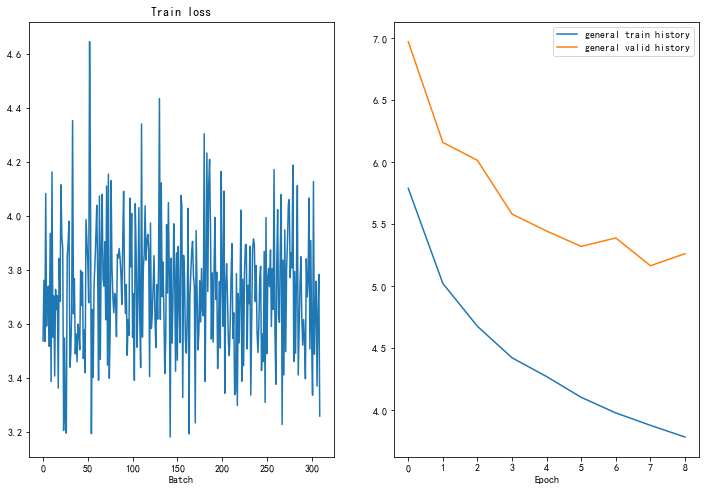

Epoch: 10 | Time: 1m 15s
	Train Loss: 3.724 | Train PPL:  41.439
	 Val. Loss: 5.142 |  Val. PPL: 171.135


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
#model.load_state_dict(torch.load('tut1-model.pt'))

<All keys matched successfully>

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
from utils import generate_translation
for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: ▁there ▁is ▁a ▁24 ▁- ▁hour ▁front ▁desk ▁at ▁the ▁property ▁.
Generated: ▁a ▁24 ▁- ▁hour ▁front ▁desk ▁. ▁property ▁. ▁.

Original: ▁free ▁wifi ▁is ▁provided ▁.
Generated: ▁free ▁wifi ▁access ▁is ▁available ▁. ▁.

Original: ▁the ▁kitchen ▁is ▁fitted ▁with ▁an ▁oven ▁.
Generated: ▁there ▁is ▁a ▁full ▁kitchen ▁with ▁a ▁dishwasher ▁and ▁a ▁refrigerator ▁. ▁.

Original: ▁free ▁parking ▁is ▁provided ▁.
Generated: ▁free ▁parking ▁is ▁available ▁on ▁site ▁.

Original: ▁on ▁- ▁site ▁parking ▁is ▁provided ▁.
Generated: ▁free ▁on ▁- ▁site ▁parking ▁.

Original: ▁daily ▁maid ▁service ▁is ▁available ▁.
Generated: ▁breakfast ▁service ▁is ▁available ▁. ▁.

Original: ▁breakfast ▁is ▁served ▁in ▁the ▁restaurant ▁.
Generated: ▁a ▁breakfast ▁buffet ▁is ▁served ▁. ▁.

Original: ▁there ▁is ▁also ▁a ▁fridge ▁.
Generated: ▁a ▁washing ▁machine ▁. ▁.

Original: ▁breakfast ▁is ▁provided ▁each ▁morning ▁.
Generated: ▁a ▁breakfast ▁breakfast ▁is ▁served ▁. ▁.



In [ ]:
generated_text, original_text = get_corpora_translations(model, test_iterator)

59it [00:04,  9.77it/s]


In [ ]:
original_text[100], generated_text[100]

(['a', 'tv', 'is', 'featured', '.'], ['a', 'tv', '.', 'channels', '.', '.'])

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

11.478493612029636

### BPE, Attention

In [ ]:
SRC = Field(tokenize=ru_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=en_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])#, random_state=42)

SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, do_attention=True)
model = Seq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

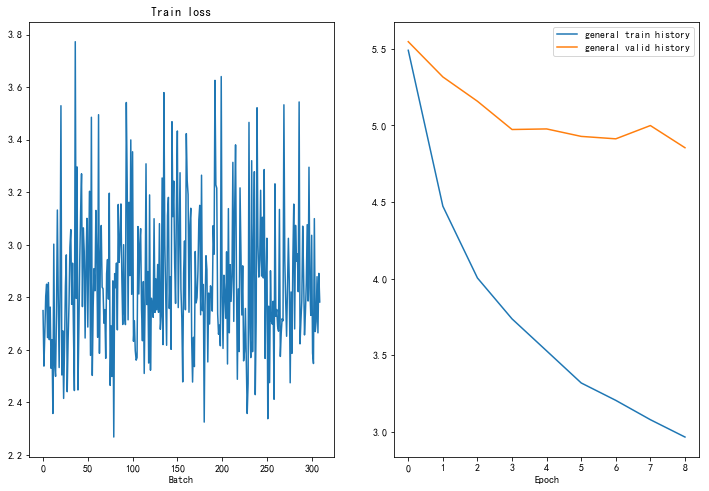

Epoch: 10 | Time: 1m 42s
	Train Loss: 2.860 | Train PPL:  17.470
	 Val. Loss: 4.991 |  Val. PPL: 147.113


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
#model.load_state_dict(torch.load('tut1-model.pt'))

<All keys matched successfully>

In [ ]:
from utils import generate_translation
batch = next(iter(test_iterator))
for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: ▁there ▁is ▁a ▁24 ▁- ▁hour ▁front ▁desk ▁at ▁the ▁property ▁.
Generated: ▁24 ▁- ▁hour ▁front ▁desk ▁is ▁available ▁. ▁hours ▁a ▁day ▁. ▁.

Original: ▁free ▁wifi ▁is ▁provided ▁.
Generated: ▁free ▁wifi ▁access ▁is ▁available ▁. ▁property ▁. ▁. ▁. ▁wifi ▁is ▁available ▁.

Original: ▁the ▁kitchen ▁is ▁fitted ▁with ▁an ▁oven ▁.
Generated: ▁an ▁oven ▁oven ▁. ▁kitchen ▁is ▁equipped ▁with ▁an ▁oven ▁. ▁oven ▁. ▁unit ▁is ▁equipped ▁with ▁an

Original: ▁free ▁parking ▁is ▁provided ▁.
Generated: ▁parking ▁is ▁free ▁. ▁charge ▁. ▁.

Original: ▁on ▁- ▁site ▁parking ▁is ▁provided ▁.
Generated: ▁parking ▁is ▁available ▁on ▁site ▁. ▁on ▁site ▁. ▁.

Original: ▁daily ▁maid ▁service ▁is ▁available ▁.
Generated: ▁maid ▁service ▁is ▁available ▁daily ▁. ▁daily ▁maid ▁service ▁is ▁available ▁. ▁rate ▁. ▁daily ▁maid ▁service

Original: ▁breakfast ▁is ▁served ▁in ▁the ▁restaurant ▁.
Generated: ▁breakfast ▁is ▁served ▁daily ▁. ▁restaurant ▁. ▁restaurant ▁. ▁restaurant ▁. ▁restaurant ▁. ▁restaurant ▁.

/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
generated_text, original_text = get_corpora_translations(model, test_iterator)

0it [00:00, ?it/s]/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
59it [00:04,  7.46it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

18.604971750619363

### Attention

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])#, random_state=42)

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, do_attention=True)
model = Seq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

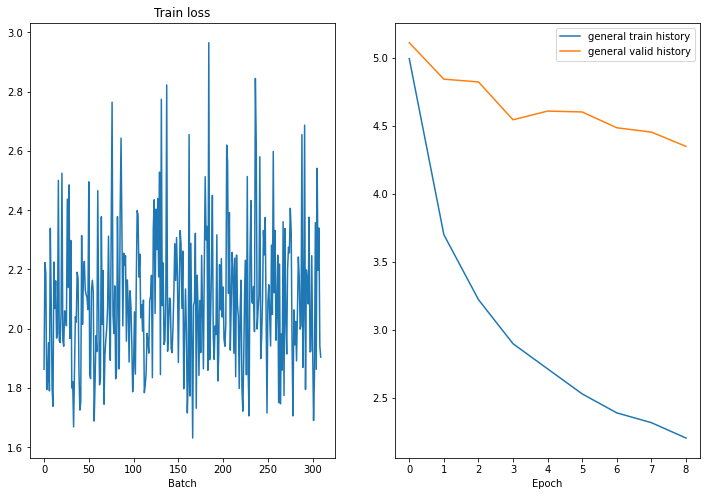

torch.Size([40, 64, 6707])
torch.Size([39, 128, 6707])
torch.Size([39, 128, 6707])
torch.Size([21, 128, 6707])
torch.Size([22, 128, 6707])
torch.Size([20, 128, 6707])
torch.Size([19, 128, 6707])
torch.Size([21, 128, 6707])
torch.Size([21, 128, 6707])
torch.Size([24, 128, 6707])
torch.Size([27, 128, 6707])
torch.Size([25, 128, 6707])
torch.Size([23, 128, 6707])
torch.Size([27, 128, 6707])
torch.Size([31, 128, 6707])
torch.Size([33, 128, 6707])
torch.Size([32, 128, 6707])
torch.Size([37, 128, 6707])
torch.Size([35, 128, 6707])
torch.Size([39, 128, 6707])
torch.Size([42, 128, 6707])
torch.Size([45, 128, 6707])
torch.Size([68, 68, 6707])
Epoch: 10 | Time: 1m 19s
	Train Loss: 2.095 | Train PPL:   8.129
	 Val. Loss: 4.573 |  Val. PPL:  96.814


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
from utils import generate_translation
batch = list(iter(test_iterator))[42]
for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: car and bicycle hire is also available and palma airport is 80 km away .
Generated: car hire and car hire are car airport , 80 km away palma de mallorca airport is 80 km away . . km away . airport is 80 km away . .

Original: the continental breakfast is served daily and includes homemade yogurts , jams and bread , and cakes with fruits from the garden .
Generated: a continental breakfast breakfast , homemade jams , bread and pastries , pastries and fruit fruit and fruit . .

Original: the residences centennial park offers luxury self - contained accommodation with free wifi and free on - site parking .
Generated: this theme inn offers a - catering accommodation with free wifi access and free parking . . free . free parking

Original: it also features a living area and the bathroom is fitted with a shower , a hairdryer and free toiletries .
Generated: the is a seating area and a bathroom with shower , hairdryer and free toiletries . . toiletries . toiletries . .

Original: pa

In [ ]:
generated_text, original_text = get_corpora_translations(model, test_iterator)

59it [00:01, 19.38it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

26.50065307930803

# DONE

### LM -> Decoder, Attention

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])#, random_state=42)

SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
with open('data.txt', 'r') as f1, open('en.txt', 'w') as f2:
    for line in f1.readlines():
        en = line.split('\t')[0]
        print(en, file=f2)
LM_FIELD = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)
lm_dataset = torchtext.data.TabularDataset('en.txt', format='tsv',
    fields=[('trg', TRG)])
lm_train, lm_val = lm_dataset.split(split_ratio=[0.8, 0, 0.2])
LM_FIELD.build_vocab(lm_train)
def _lm_len_sort_key(x):
    return len(x.trg)
lm_train_iterator, lm_valid_iterator = BucketIterator.splits(
    (lm_train, lm_val), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_lm_len_sort_key
)

In [ ]:
next(iter(lm_train_iterator))


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 44x128 (GPU 0)]

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
lm = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

In [ ]:
def train_lm(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        trg = batch.trg
        optimizer.zero_grad()
        h = torch.zeros(N_LAYERS, trg.size(1), model.hid_dim, device=device)
        c = torch.zeros(N_LAYERS, trg.size(1), model.hid_dim, device=device)
        output, _, _ = model(trg, h, c, None)
        output = output[:-1].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate_lm(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            trg = batch.trg
            h = torch.zeros(N_LAYERS, trg.size(1), model.hid_dim).to(device)
            c = torch.zeros(N_LAYERS, trg.size(1), model.hid_dim).to(device)
            output, _, _ = model(trg, h, c, None)
            output = output[:-1].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

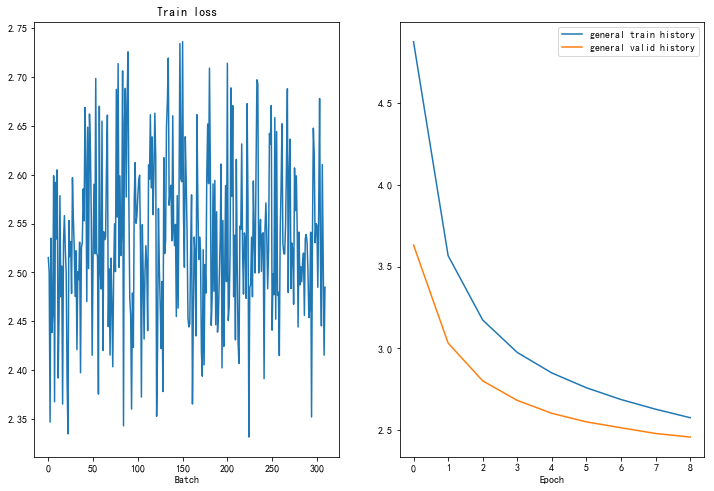

Epoch: 10 | Time: 0m 21s
	Train Loss: 2.533 | Train PPL:  12.593
	 Val. Loss: 2.439 |  Val. PPL:  11.456


In [ ]:
N_EPOCHS = 10
CLIP = 1
train_history = []
valid_history = []
optimizer_lm = torch.optim.Adam(lm.parameters())
lm.to(device)
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train_lm(lm, lm_train_iterator, optimizer_lm, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_lm(lm, lm_valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


In [ ]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, do_attention=True)
dec.load_state_dict(lm.state_dict(), strict=False)
model = Seq2Seq(enc, dec, device).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

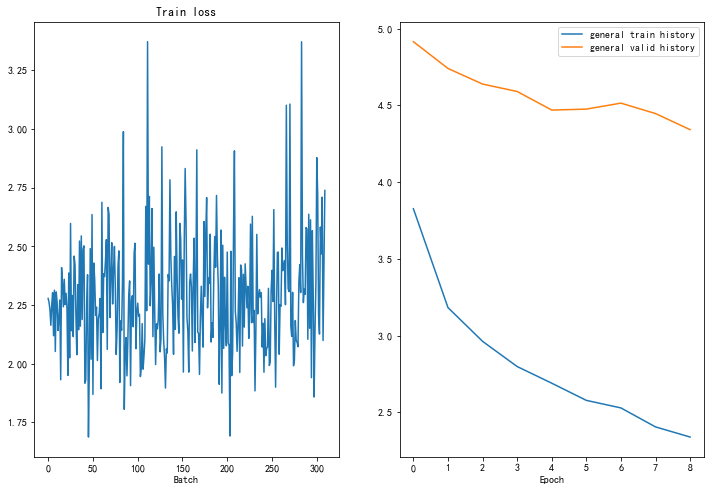

Epoch: 10 | Time: 1m 7s
	Train Loss: 2.289 | Train PPL:   9.869
	 Val. Loss: 4.434 |  Val. PPL:  84.274


In [ ]:
N_EPOCHS = 10
CLIP = 1
train_history = []
valid_history = []

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
from utils import generate_translation
batch = list(iter(test_iterator))[42]
for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: this hotel is situated just off the a2 motorway , a 15 - minute drive from central hanover and the hanover exhibition centre .
Generated: this off interstate 64 , this hotel is a 15 - minute drive from the city centre and the city centre and the exhibition centre .

Original: the hotel has an outdoor pool , and a terrace with extensive sea views . all rooms have air conditioning and free wi - fi .
Generated: it features an outdoor pool , a terrace with panoramic sea views and air - conditioned rooms with free wi - fi . . air - conditioned rooms with free

Original: benefit from the function room which is ideal for , weddings , business meetings , and other special .
Generated: the is ideal for visiting the , , , , , , , , , , , , , , , , , , , , and and and and .

Original: all the air - conditioned apartments at partner guest house include modern décor and a flat - screen tv .
Generated: all air - conditioned apartments at feature a flat - screen tv and air conditioning .

O

In [ ]:
generated_text, original_text = get_corpora_translations(model, test_iterator)

59it [00:01, 29.69it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

24.18803816418153